In [1]:
import os
import sys
from contextlib import nullcontext
import cv2
from tqdm import tqdm
import torch
from PIL import Image
from einops import repeat
from pytorch_lightning import seed_everything
from torch import autocast

from common import replace_object
from common import parser, OmegaConf, load_model_from_config, latent_to_image, \
    load_img, make_dataset_txt, data_to_dict

lldm_dir = os.path.abspath('./')
sys.path.append(lldm_dir)
from ldm.models.diffusion.ddim import DDIMSampler

In [2]:
from safetensors.torch import load_model
from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys: pass")
    #         print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys: pass")
    model.eval()
    return model


def load_model_from_config_safe(config, safetensors, verbose=False):
    model = instantiate_from_config(config.model)
    m, u = load_model(model, safetensors, strict=False)
#     m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys: pass")
#             print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys: pass")
    model.eval()
    return model

In [3]:
import numpy as np
def get_mask_dilate(mask_path, dilate_args=None):
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = img_mask / 255
    img_mask[img_mask !=0] = 1
    if dilate_args is not None:
        kernel = np.ones((dilate_args[0], dilate_args[0]), dtype=np.uint8)
        img_mask = cv2.dilate(img_mask, kernel, dilate_args[1])
    img_mask = cv2.resize(img_mask, (64, 64), interpolation=cv2.INTER_LANCZOS4)
    img_mask[img_mask > 0.5] = 1
    img_mask[img_mask !=1] = 0
    img_mask = torch.Tensor(img_mask).unsqueeze(0).unsqueeze(0).cuda()
    return img_mask

In [4]:
# prepare
config = OmegaConf.load('configs/stable-diffusion/v1-inference.yaml')
model = load_model_from_config(config, 'models/ldm/stable-diffusion-v1/model.ckpt')
device = torch.device("cuda")
model = model.to(device)
sampler = DDIMSampler(model)
seed_everything(42)
model.cond_stage_model = model.cond_stage_model.to(device)
precision_scope = autocast

Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.17.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.10.mlp.fc2.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.19.layer_norm1.weight', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.layer_norm1.weight', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.15.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.mlp.fc2.weight', 'vision_model.enco

In [5]:
seed_everything(42)
DDIM_STEPS=50
root_dir = 'demo/' # specify the directory where input images and their masks are stored
sampler.make_schedule(ddim_num_steps=DDIM_STEPS, ddim_eta=0.0, verbose=False)

Global seed set to 42


In [6]:
##########################   DIFFEDIT  ##########################################
from common import predict_mask
RATIO = 1
SCALE = 7.5
DDIM_STEPS = 50
root_dir = 'demo/'
out_dir = os.path.join('results', 'diffedit')
os.makedirs(out_dir, exist_ok=True)
prompts_dict = data_to_dict(make_dataset_txt('demo/orig_prompt.txt'))
seed_everything(42)
edit_prompts = {
    0: "A photo of a duck on a flower",
    1: "A robot is watching a laptop",
    2: "A girl with white straight hair sitting on the grass",
    3: "One rabbit and one dog sitting on the grass",
    6: "A happy corgi running on the grass",
    7: "a Children drawing of a pencil drawing of a river",
    8: "A cute corgi sitting on the snow",
    9: "A bird on the left and an owl on the right standing on a branch",
    11: "A teddy bear is surfing on the sea",
    12: "A panda wearing a red hat green shirt and blue pan",
    14: "A photo of a butterfly on a mushroom",
    16: "A cat wearing blue leather jacket", # set RATIO=0.8
    18: "Two real birds sitting on a branch" # set RATIO=0.8
}
name = 0
with torch.no_grad():
    with precision_scope(device.type):
        with model.ema_scope():

            name = str(name)
            img_path = os.path.join(root_dir, 'img_dir/%s.png' % name)
            tgt_image = repeat(
                load_img(img_path, 512, 512).cuda(), '1 ... -> b ...', b=1)
            prompt = prompts_dict[name]
            print(prompt)
            edit_prompt = edit_prompts[int(name)]
            print(edit_prompt)

            tgt_mask = None
#             tgt_mask = get_mask_dilate(os.path.join(root_dir, 'masks/%s.png' % name))

            uc = None
            if SCALE != 1.0:
                uc = model.get_learned_conditioning([""])
            src_cond = model.get_learned_conditioning([prompt])
            tgt_cond = model.get_learned_conditioning([edit_prompt])

            t_enc = int(DDIM_STEPS * RATIO)
            init_latent = model.get_first_stage_encoding(
                model.encode_first_stage(tgt_image))

            if tgt_mask is None:
                print('Diffedit mask generation')
                tgt_mask = predict_mask(
                    sampler, model, src_cond, tgt_cond, uc, init_latent, 3, DDIM_STEPS)

            latents = sampler.ddim_loop(init_latent, uc, t_enc)

            def corrector_fn(x, index):
                # index=0-25
                x = x * tgt_mask + (1 - tgt_mask) * latents[index]
                return x

            noised_sample = latents[-1].clone()
            recover_latent = sampler.diffedit(noised_sample, tgt_cond, t_enc,
                                              unconditional_guidance_scale=SCALE,
                                              unconditional_conditioning=uc,
                                              corrector_fn=corrector_fn)

            res = latent_to_image(model, recover_latent)
            Image.fromarray(res[0]).save(
                out_dir + '/%s.png' % name)
            print('Results are saved to %s' % out_dir)

Global seed set to 42


A photo of a butterfly on a flower
A photo of a duck on a flower
Diffedit mask generation


Encoding image: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.85it/s]


Running DDIM Sampling with 50 timesteps


Decoding image: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.25it/s]


Results are saved to results/diffedit


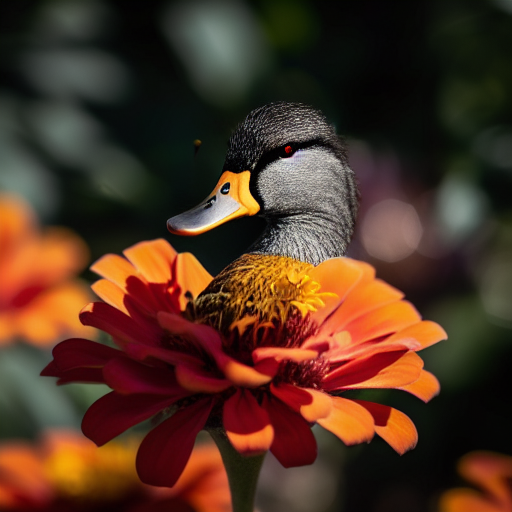

In [7]:
Image.fromarray(res[0])